In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style()

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os, sys, time
import cPickle as pickle
sys.path.append('../EXP/')
import ClevelandMcGill as C
reload(C)

<module 'ClevelandMcGill' from '../EXP/ClevelandMcGill/__init__.pyc'>

In [3]:
NOISE = True

In [122]:
def in_array(haystack, needle):
  for h in haystack:
    if np.array_equal(needle, h):
      return True
  return False

train_target = 60000
val_target = 20000
test_target = 20000

X_train = np.zeros((train_target, 100, 100), dtype=np.float32)
y_train = np.zeros((train_target, 5), dtype=np.float32)
train_counter = 0

X_val = np.zeros((val_target, 100, 100), dtype=np.float32)
y_val = np.zeros((val_target, 5), dtype=np.float32)
val_counter = 0

X_test = np.zeros((test_target, 100, 100), dtype=np.float32)
y_test = np.zeros((test_target, 5), dtype=np.float32)
test_counter = 0

t0 = time.time()

all_counter = 0
while train_counter < train_target or val_counter < val_target or test_counter < test_target:
  
  all_counter += 1
  
  data, label = C.Figure3.generate_datapoint()
  
  

  
  
  pot = np.random.choice(3, p=([.6,.2,.2]))

  if pot == 0 and train_counter < train_target:
    # a training candidate
    if in_array(y_val, label) or in_array(y_test, label):
      # no thank you
      continue
      
    #
    image = C.Figure3.data_to_barchart(data)
    image = image.astype(np.float32)
      
    # add noise?
    if NOISE:
      image += np.random.uniform(0, 0.05,(100,100))
      
    # safe to add to training
    X_train[train_counter] = image
    y_train[train_counter] = label
    train_counter += 1
    
  elif pot == 1 and val_counter < val_target:
    # a validation candidate
    if in_array(y_test, label) or in_array(y_train, label):
      # no thank you
      continue
      
    #
    image = C.Figure3.data_to_barchart(data)
    image = image.astype(np.float32)
      
    # add noise?
    if NOISE:
      image += np.random.uniform(0, 0.05,(100,100))
      
    # safe to add to validation
    X_val[val_counter] = image
    y_val[val_counter] = label
    val_counter += 1
  
  elif pot == 2 and test_counter < test_target:
    # a test candidate
    if in_array(y_val, label) or in_array(y_train, label):
      # no thank you
      continue
      
    #
    image = C.Figure3.data_to_barchart(data)
    image = image.astype(np.float32)
      
    # add noise?
    if NOISE:
      image += np.random.uniform(0, 0.05,(100,100))
      
    # safe to add to test
    X_test[test_counter] = image
    y_test[test_counter] = label
    test_counter += 1
  
  
  
print 'Done', time.time()-t0, 'seconds (', all_counter, 'iterations)'

KeyboardInterrupt: 

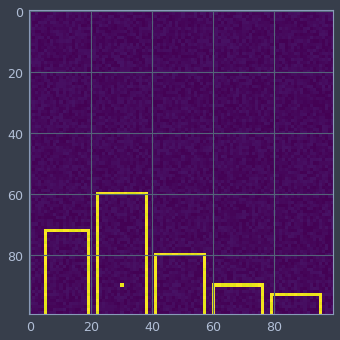

In [102]:
imshow(X_train[9])

In [103]:
print y_train[9]

[ 1.          0.48717949  0.23076923  0.15384616  0.69230771]


In [112]:
X_min = min(X_train.min(), X_val.min(), X_test.min())
X_max = max(X_train.max(), X_val.max(), X_test.max())
y_min = min(y_train.min(), y_val.min(), y_test.min())
y_max = max(y_train.max(), y_val.max(), y_test.max())

# scale in place
X_train -= X_min
X_train /= (X_max - X_min)
X_val -= X_min
X_val /= (X_max - X_min)
X_test -= X_min
X_test /= (X_max - X_min)
y_train -= y_min
y_train /= (y_max - y_min)
y_val -= y_min
y_val /= (y_max - y_min)
y_test -= y_min
y_test /= (y_max - y_min)

# normalize to -.5 .. .5
X_train -= .5
X_val -= .5
X_test -= .5

print 'memory usage', (X_train.nbytes + X_val.nbytes + X_test.nbytes + y_train.nbytes + y_val.nbytes + y_test.nbytes) / 1000000., 'MB'

memory usage 4.002 MB


In [113]:
X_train_3D = np.stack((X_train,)*3, -1)
X_val_3D = np.stack((X_val,)*3, -1)
X_test_3D = np.stack((X_test,)*3, -1)
print 'memory usage', (X_train_3D.nbytes + X_val_3D.nbytes + X_test_3D.nbytes) / 1000000., 'MB'

memory usage 12.0 MB


In [114]:
import keras.applications

VGG19 = keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(100,100,3))

t0 = time.time()
X_train_3D_features = VGG19.predict(X_train_3D, verbose=True)
X_val_3D_features = VGG19.predict(X_val_3D, verbose=True)
X_test_3D_features = VGG19.predict(X_test_3D, verbose=True)
print 'VGG19 features done after', time.time()-t0
print 'memory usage', (X_train_3D_features.nbytes + X_val_3D_features.nbytes + X_test_3D_features.nbytes) / 1000000., 'MB'

Using TensorFlow backend.


20/20 [==============================] - 0s 4ms/step
VGG19 features done after 2.33642792702
memory usage 1.8432 MB


In [115]:
feature_shape = X_train_3D_features.shape[1] * X_train_3D_features.shape[2] * X_train_3D_features.shape[3]

In [116]:
from keras import models
from keras import layers
from keras import optimizers
import keras.applications
from keras import backend as K
from keras.utils.np_utils import to_categorical

MLP = models.Sequential()

MLP.add(layers.Dense(256, activation='relu', input_dim=feature_shape))
MLP.add(layers.Dropout(0.5))
MLP.add(layers.Dense(5, activation='linear')) # REGRESSION

sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
MLP.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mse', 'mae']) # MSE for regression

In [117]:
t0 = time.time()
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]

history = MLP.fit(X_train_3D_features.reshape(X_train_3D_features.shape[0], feature_shape), \
                  y_train, \
                  epochs=1000, \
                  batch_size=32, \
                  validation_data=(X_val_3D_features.reshape(X_val_3D_features.shape[0], feature_shape), y_val),
                  callbacks=callbacks,
                  verbose=True)
print 'Fitting done', time.time()-t0

Train on 60 samples, validate on 20 samples
Epoch 1/1000
60/60 [==============================] - 0s 4ms/step - loss: 1.0959 - mean_squared_error: 1.0959 - mean_absolute_error: 0.8334 - val_loss: 0.3723 - val_mean_squared_error: 0.3723 - val_mean_absolute_error: 0.4607
Epoch 2/1000
60/60 [==============================] - 0s 172us/step - loss: 0.8263 - mean_squared_error: 0.8263 - mean_absolute_error: 0.7251 - val_loss: 0.1621 - val_mean_squared_error: 0.1621 - val_mean_absolute_error: 0.3138
Epoch 3/1000
60/60 [==============================] - 0s 197us/step - loss: 0.6789 - mean_squared_error: 0.6789 - mean_absolute_error: 0.6707 - val_loss: 0.0685 - val_mean_squared_error: 0.0685 - val_mean_absolute_error: 0.2090
Epoch 4/1000
60/60 [==============================] - 0s 181us/step - loss: 0.4996 - mean_squared_error: 0.4996 - mean_absolute_error: 0.5647 - val_loss: 0.0720 - val_mean_squared_error: 0.0720 - val_mean_absolute_error: 0.2059
Epoch 5/1000
60/60 [==========================

In [118]:
y_pred = MLP.predict(X_test_3D_features.reshape(X_test_3D_features.shape[0], feature_shape))

In [119]:
import sklearn.metrics
np.log2(sklearn.metrics.mean_absolute_error(y_pred*100, y_test*100)+.125)

4.5427474426618515

In [120]:
y_pred

array([[ 0.77091002,  0.33263478,  0.34432322,  0.32688344,  0.49734765],
       [ 0.80820125,  0.31629801,  0.31003672,  0.35778007,  0.46504706],
       [ 0.82879877,  0.39840612,  0.34554276,  0.28407133,  0.420955  ],
       [ 0.80425048,  0.33704057,  0.35294485,  0.35330889,  0.47488531],
       [ 0.65908182,  0.37139633,  0.3675468 ,  0.52917147,  0.47825524],
       [ 0.80385697,  0.32135966,  0.2764664 ,  0.33366418,  0.48372144],
       [ 0.79887247,  0.35977432,  0.4166345 ,  0.34409648,  0.45673174],
       [ 0.74923265,  0.25428361,  0.27187079,  0.57882059,  0.55992627],
       [ 0.9170059 ,  0.28662544,  0.39203429,  0.33154258,  0.43590394],
       [ 0.76540363,  0.32167339,  0.36205593,  0.38338569,  0.49142075],
       [ 0.89373362,  0.36924312,  0.39004463,  0.35853258,  0.47620416],
       [ 0.74704129,  0.32781756,  0.41590407,  0.4154093 ,  0.44078767],
       [ 0.90939957,  0.31934139,  0.38092017,  0.30308142,  0.43095118],
       [ 0.7997973 ,  0.40932703,  0.4

In [121]:
y_test

array([[ 1.        ,  0.63861006,  0.18687257,  0.51814675,  0.0965251 ],
       [ 1.        ,  0.52244902,  0.04489797,  0.42693877,  0.6179592 ],
       [ 1.        ,  0.02077922,  0.79740262,  0.32467535,  0.66233766],
       [ 1.        ,  0.77058822,  0.41008404,  0.50840336,  0.01680672],
       [ 1.        ,  0.87619048,  0.19523811,  0.0404762 ,  0.41190475],
       [ 1.        ,  0.50476193,  0.0404762 ,  0.34999999,  0.62857145],
       [ 1.        ,  0.03233083,  0.20827068,  0.82406014,  0.2962406 ],
       [ 1.        ,  0.60000002,  0.2857143 ,  0.        ,  0.40000001],
       [ 1.        ,  0.45974025,  0.08831169,  0.56103897,  0.69610393],
       [ 1.        ,  0.28809524,  0.10238095,  0.72142857,  0.41190475],
       [ 1.        ,  0.66571426,  0.55428576,  0.10857143,  0.8142857 ],
       [ 1.        ,  0.25714287,  0.50476193,  0.75238097,  0.00952381],
       [ 1.        ,  0.79107141,  0.09464286,  0.33839285,  0.68660712],
       [ 1.        ,  0.10238095,  0.7